In [1]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from scipy.optimize import minimize
from scipy import optimize
import f_class
from GP import GP
from GP_grad import GP_grad
from TrustGD import TrustGD
import time
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *

eps = np.sqrt(np.finfo(float).eps)

Noise = False
Noise_level = 0.00 # noise-free

#### High-dimensional $f$

In [2]:
objective = f_class.Hartmann_6(Noise, Noise_level)
objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=10) 
# objective = f_class.Rastrigin(Noise, Noise_level, dim=10)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=10).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x)  

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B.T) 
lb = B[:, 0]; ub = B[:, 1]

dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[-5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
dim:  10


In [3]:
# assuming B = L^d, cube
Diam = LA.norm(ub - lb)
Len = (ub - lb)[0]
Diam

47.43416490252569

#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))

def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [5]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [6]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [7]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

### Trust Region GD-1

In [8]:
MAX = 200 # function observations

##### 1. Setup with random points

In [9]:
# initial data
setup = 10
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = from_unit_cube(latin_hypercube(setup, dim), lb, ub)
X_fix = X

history = [(x, f(x)) for x in X]

##### 2. Build Trust Region 

In [10]:
# return x inside trust region ball
def build_TR(X, TR_c, TR_l):
    X_TR = np.vstack(list(filter(lambda x: LA.norm(x - TR_c, np.inf) < TR_l/2, [x for x in X])))
    lower_TR = np.maximum(TR_c - TR_l/2, lb)
    upper_TR = np.minimum(TR_c + TR_l/2, ub)
    return X_TR, np.vstack([lower_TR, upper_TR]).T

In [11]:
# TR_l = 0.8 * Len
# X_TR, region_TR = build_TR(X, X[0], TR_l)


# pl.figure(figsize=(6, 6), dpi=80)
# pl.plot(X[:, 0], X[:, 1], 'o', linewidth=1, markersize=8)
# pl.plot(X_TR[:, 0], X_TR[:, 1], 'x', linewidth=2, markersize=8)

# pl.xlim(B[0])
# pl.ylim(B[1])

# pl.gca().add_patch(pl.Rectangle(X[0] - (TR_l/2) * np.ones(dim), TR_l, TR_l, color='blue', alpha=0.1))
# pl.show()

### Trust Region GD-1

In [12]:
np.set_printoptions(precision=4)
cost = setup

# L0: starting length of trust region
S0 = 0.8 * Len
S = S0
S
# gp.posterior(w), gp._normal(f(w))
# gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

12.0

In [13]:
# plot
n_Grid = 100
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(10000, 2)

In [14]:
MAX_Fal = 20
MAX_Imp = 3
MAX_S = 1.6 * S0
MIN_S = (1/2)**7 * S0
xc = X[np.argmin(f(X))]

In [15]:
while MAX >= cost:
    print('.... new lineBO')
    # re-start
    if cost != setup:
        S = S0
        xc = np.random.uniform(lb, ub, size=(1, dim))
        X = np.vstack([X, xc])
        cost += 1
    
    f_xc = f(xc)
    GD_Fal = 0
    GD_Imp = 0
    
    Xtr, Rtr = build_TR(X, xc, S)
    while S >= MIN_S and MAX >= cost:
        print(cost, end = '. ')
        print('S = ', S)
        
        # fit a new GP with pts inside TR
        gp = GP_grad(Rtr, Noise, Noise_level, compress=True)
        gp.set_data(Xtr, f(Xtr))
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        gp.fit()
        
#         x = gp.thompson_sample(n_mesh=5000)
        
        # GD from xc to get new x
        GD = TrustGD(gp, xc, f, S)
        x, _ = GD.update(commit=True)
        X = np.vstack([X, x])
        cost += 1

        # update GD_Fal & GD_Imp
        delta = np.abs(1e-3 * f_xc)
        if f(x) < f_xc - delta:
            GD_Fal = 0
            GD_Imp += 1
        else:
            GD_Fal += 1
            GD_Imp = 0
            
        if f(x) < f_xc:
            # shift xc
            xc = x
            f_xc = f(xc)
            
        # tune xc a little
        for i in range(10):
            gp.add_data(x, f(x))
            ls, var = gp.optimize()
            gp.set_hyper(ls, var)
            gp.fit()

            lr = 0.1 * MIN_S
            gt = gp.grad_sample(xc)
            gt = gt / LA.norm(gt)
            xc = np.clip(xc - lr * gt, gp.B[:, 0], gp.B[:, 1])
            
        # update S
        if MAX_Fal == GD_Fal:
            S = S / 2
            GD_Fal = 0
            print('Shrink the region: %.4f ' % S)

        if MAX_Imp == GD_Imp:
            S = min(S * 2, MAX_S)
            GD_Imp = 0
            print('Expand the region: %.4f ' % S)
          
        # new TR = (xc, R)
        Xtr, Rtr = build_TR(X, xc, S)  # get the points only inside the trust region and the region of TR
        
        # plot
#         pl.figure(figsize=(6, 6), dpi=80)
#         pl.plot(X[:, 0], X[:, 1], 'o', linewidth=1, markersize=6)
#         pl.plot(Xtr[:, 0], Xtr[:, 1], 'x', linewidth=1, markersize=6)

#         pl.xlim(B[0])
#         pl.ylim(B[1])
        
#         pl.gca().add_patch(pl.Rectangle(np.squeeze(xc) - (S/2) * np.ones(dim), S, S, color='blue', alpha=0.1))
#         pl.contour(X1, X2, f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
#         pl.show()
        
        # verbose
        print('x = ', x)
        print('    Normal f(w): %.4f ' % gp._normal(f(x).item()) )
        print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(x))
        print('    f(x): %.4f ' % f(x).item())
        
        history.append( (x, f(x)) )

        # print out y_best, cost
        y_best = np.min(f(X))
        arg_y_best = np.argmin(f(X))
        print('    y best, No: ', y_best, [arg_y_best])
        print()
        
print('Max Cost reached = ', cost)

.... new lineBO
10. S =  12.0
prev [12.2565]
GD [12.2565]
x =  [ 4.1233 -1.8854  3.9517  2.4558 -4.1815 -3.2377  7.9309  0.2897 -4.3767
  1.0654]
    Normal f(w): -1.2085 
    Predict f(w): (0.0000, 0.0500) 
    f(x): 12.2565 
    y best, No:  12.25647316106914 [10]

11. S =  12.0
prev [12.2565]
GD [12.2565]
x =  [ 8.8288 -3.3495  7.6932  4.7959 -1.7806  2.4334  6.0573  2.1032  0.9698
  1.9835]
    Normal f(w): 1.3424 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 13.6719 
    y best, No:  12.25647316106914 [10]

12. S =  12.0
prev [12.2565]
GD [12.2565]
x =  [ 5.0774 -0.213   6.5941  6.3636 -2.5584  0.98    8.8908  3.0107 -1.9138
  5.5099]
    Normal f(w): 1.4898 
    Predict f(w): (0.0000, 1.0000) 
    f(x): 14.0610 
    y best, No:  12.25647316106914 [10]

13. S =  12.0
prev [10.8965]
GD [10.8965]
x =  [ 4.6205  0.7719  0.1201 -2.4361 -2.4839 -4.0734  3.9941  4.2104 -2.8974
 -1.5946]
    Normal f(w): -3.6600 
    Predict f(w): (0.0000, 1.0000) 
    f(x): 10.8965 
    y best, No:  1

prev [9.0701]
GD [9.0701]
x =  [ 3.1837  4.1049  0.1197 -2.0649 -0.6852 -0.0771  2.6522  5.8909  1.4173
  2.6605]
    Normal f(w): 29.8025 
    Predict f(w): (0.0000, 1.0000) 
    f(x): 10.2234 
    y best, No:  9.070104739958 [21]

44. S =  6.0
prev [9.0701]
GD [9.0701]
x =  [ 2.2028  4.6691 -2.4261 -4.8712  2.9357  0.6128  2.4128  4.6913  2.857
  1.2573]
    Normal f(w): 3.3991 
    Predict f(w): (0.0013, 0.9369) 
    f(x): 11.2705 
    y best, No:  9.070104739958 [21]

45. S =  6.0
prev [8.9858]
GD [8.9858]
x =  [ 0.4182  1.7268 -2.0892 -2.9825 -1.5095  0.9592  4.4661  3.2703  0.3195
 -0.1851]
    Normal f(w): -1.0463 
    Predict f(w): (-0.6405, 0.6481) 
    f(x): 8.9858 
    y best, No:  8.985752445467739 [45]

46. S =  6.0
prev [8.9858]
GD [8.9858]
x =  [ 3.2552  3.3648 -1.2863 -2.0765 -2.0575 -0.5149  1.7421  5.8843 -2.5633
  2.5563]
    Normal f(w): 2.4711 
    Predict f(w): (0.1183, 0.8951) 
    f(x): 10.6013 
    y best, No:  8.985752445467739 [45]

47. S =  6.0
prev [8.9858]

prev [7.625]
GD [7.625]
x =  [ 1.0938 -1.4926  1.0791 -0.5419 -1.3293 -2.9921  1.534   3.1568  0.5921
  1.2163]
    Normal f(w): -1.3980 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 7.6289 
    y best, No:  7.6249964607940175 [54]

78. S =  3.0
prev [7.625]
GD [7.625]
x =  [ 0.3602 -0.8709 -0.0131 -0.9599 -1.1007 -0.599   3.3438  5.9743 -1.5882
  0.9445]
    Normal f(w): 3.2698 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 8.8467 
    y best, No:  7.6249964607940175 [54]

79. S =  3.0
prev [7.625]
GD [7.625]
x =  [ 1.5019 -1.442   2.0568 -2.3188 -1.4271 -1.4459  1.5552  6.1174  0.0191
 -0.8738]
    Normal f(w): 3.2246 
    Predict f(w): (-0.0000, 0.9999) 
    f(x): 9.5591 
    y best, No:  7.6249964607940175 [54]

80. S =  3.0
prev [6.8553]
GD [6.8553]
x =  [-1.1776 -0.4322  1.7356 -1.3178 -2.047  -1.0604  1.2514  3.2067 -0.8241
 -0.995 ]
    Normal f(w): -2.1770 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 6.8553 
    y best, No:  6.855260847650683 [80]

81. S =  3.0
prev [6.8

prev [5.1061]
GD [5.1061]
x =  [-0.8078  2.468  -0.0424  0.0326 -1.7565  1.228   0.5151  1.1251  0.4299
  0.5887]
    Normal f(w): 0.3098 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 5.9050 
    y best, No:  5.106063111063541 [109]

111. S =  3.0
prev [5.1061]
GD [5.1061]
x =  [-1.9037  1.0735  0.1673  0.6087 -1.7178  0.3928  0.362   0.7418  0.8132
  2.6829]
    Normal f(w): 1.1243 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 6.3140 
    y best, No:  5.106063111063541 [109]

112. S =  3.0
prev [4.7582]
GD [4.7582]
x =  [-0.7964  0.3932 -0.3342 -1.6524 -0.2973 -1.0034  0.05    1.0868 -1.0967
  0.7109]
    Normal f(w): -2.3664 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 4.7582 
    y best, No:  4.758179160645263 [112]

113. S =  3.0
prev [4.7582]
GD [4.7582]
x =  [-1.0049 -0.698   0.4397 -0.5897  0.8931 -1.5409  1.5154  1.9742 -1.6636
  2.0075]
    Normal f(w): 9.1603 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 6.5255 
    y best, No:  4.758179160645263 [112]

114. S =  3.0

prev [4.2695]
GD [4.2695]
x =  [ 0.9875  0.0833  0.735  -0.9403  0.1264 -0.511   0.8686  2.428  -0.3966
  2.691 ]
    Normal f(w): 1.3691 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 6.1696 
    y best, No:  4.2694605120602915 [135]

144. S =  3.0
prev [4.2695]
GD [4.2695]
x =  [-0.8693 -0.177  -1.5864 -0.0412  0.1324 -1.9923 -1.0113  1.8133 -0.9981
  0.2097]
    Normal f(w): -0.8726 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 5.0055 
    y best, No:  4.2694605120602915 [135]

145. S =  3.0
prev [4.2695]
GD [4.2695]
x =  [-0.3346  0.0431 -0.8718 -1.3151  0.365   0.4764 -1.4923  0.9849  0.8208
  0.0511]
    Normal f(w): -1.3377 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 4.7179 
    y best, No:  4.2694605120602915 [135]

146. S =  3.0
prev [4.2695]
GD [4.2695]
x =  [-0.1665 -1.769   0.3411  0.6131  0.9011 -1.8759  0.1757  1.4431 -1.1427
  1.0616]
    Normal f(w): 0.2096 
    Predict f(w): (0.0000, 1.0000) 
    f(x): 5.5192 
    y best, No:  4.2694605120602915 [135]

147. S = 

prev [3.9243]
GD [3.9243]
x =  [-0.2255 -0.2063 -0.5786  1.3544  0.9198 -0.9936 -0.5313  0.8622  0.3016
  0.2386]
    Normal f(w): -0.2315 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 4.3978 
    y best, No:  3.924292854693459 [170]

177. S =  1.5
prev [3.9243]
GD [3.9243]
x =  [-0.0596 -1.2221 -1.5437  0.5676  1.0396 -1.0161 -0.6802 -0.2145  0.63
  0.8256]
    Normal f(w): 0.8668 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 4.8966 
    y best, No:  3.924292854693459 [170]

178. S =  1.5
prev [3.9243]
GD [3.9243]
x =  [-0.7739 -0.3336 -1.3254  0.8894  0.318  -0.2602 -1.5096  0.6688 -0.216
  0.3762]
    Normal f(w): 0.7583 
    Predict f(w): (-0.0000, 1.0000) 
    f(x): 4.8845 
    y best, No:  3.924292854693459 [170]

179. S =  1.5
prev [3.9243]
GD [3.9243]
Shrink the region: 0.7500 
x =  [-0.9128 -0.7599 -0.7341  0.699   0.559  -0.8746 -1.1168 -0.0887 -0.7635
  1.1084]
    Normal f(w): -0.3980 
    Predict f(w): (0.0001, 1.0000) 
    f(x): 4.4003 
    y best, No:  3.924292854693

<ipython-input-16-2932aa1215d3>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), ".", lw=0.5, markersize=8)
<ipython-input-16-2932aa1215d3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)


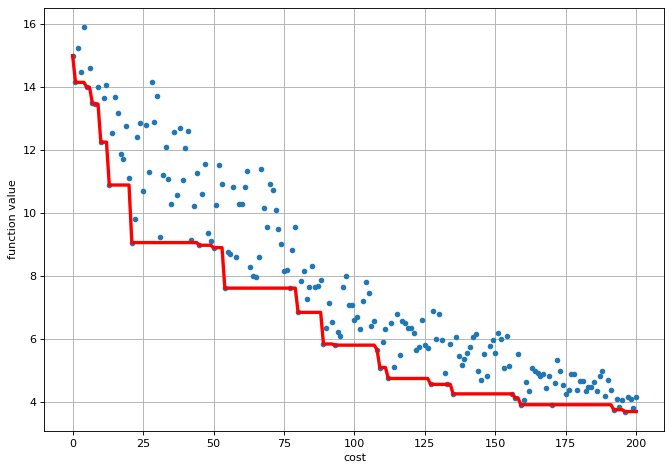

In [16]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), ".", lw=0.5, markersize=8)
pl.xlabel("cost")

pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)
pl.ylabel("function value")
# pl.ylim([0, 25])
pl.grid(True)

## Minima of GD

In [18]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([ 0.022 , -0.0664, -0.0131, -0.0897, -0.0705, -0.061 ,  0.0116,
         0.0105, -0.0842,  0.0846]),
 0.42375419518758806,
 4)

In [18]:
gp.get_normal()

(9.010046032486827, 2.5899310610964426)

In [19]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### TuRBO

### *Thompson Sampling, UCB*

In [17]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [21]:
cost = setup 

while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=2000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

10. w:  [-2.9708  7.9098  9.4221 -4.0053  1.6135 -3.4827 -4.0064 -4.5825  6.7736
  3.2006]
  f(w):  14.750124728125018
  y_best:  12.745884822492366

11. w:  [ 3.4942  0.8941  2.9477  1.1468  2.9419  9.0332  8.535   5.0797 -3.0149
 -1.6345]
  f(w):  13.534869049727783
  y_best:  12.745884822492366

12. w:  [ 3.1126e-02  4.6312e-01  5.9026e+00 -3.6032e+00  7.7876e+00  9.6626e+00
  5.1374e+00  2.2563e-03  3.3669e-01  5.2061e+00]
  f(w):  14.321720718351742
  y_best:  12.745884822492366

  # Optimal (ls, var) =  (0.6426335219372731, 0.9999999818513834)
13. w:  [ 5.9089 -0.899  -1.6398 -3.0889  6.2784  2.5464  1.6812  3.4562  8.7511
  1.3984]
  f(w):  13.434938602650307
  y_best:  12.745884822492366

14. w:  [-3.1661  9.0737  7.7185  9.0847  0.857   4.8028 -0.5554  2.016   0.4084
  8.0717]
  f(w):  14.988935800406532
  y_best:  12.745884822492366

15. w:  [-3.921   1.4678 -4.6091  9.5364  0.286   8.5358 -0.8271  0.1427  0.914
  9.9346]
  f(w):  15.083842228605235
  y_best:  12.745884822492

59. w:  [ 4.9879  3.3068  9.9317 -0.1059 -3.6545  1.5059  5.7612  3.9657  2.2322
  3.4209]
  f(w):  13.706411634689882
  y_best:  9.647632107904009

60. w:  [ 0.4492 -3.2203  4.7759  3.5798  5.838  -4.3799  0.9159  9.025  -3.5863
 -1.8605]
  f(w):  13.510822959553572
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.9772620664418414, 0.9999999759931035)
61. w:  [ 8.5755  7.9293 -1.1431  0.6078 -2.5505  8.2137  7.6275 -0.3505  4.3384
 -0.6356]
  f(w):  15.184916808573336
  y_best:  9.647632107904009

62. w:  [ 4.8916 -4.9046  5.4557  7.7557 -4.3698  1.3536 -1.1063  2.0261  0.897
  3.2907]
  f(w):  12.885730268811445
  y_best:  9.647632107904009

63. w:  [-0.3909  3.5814  2.9704  0.7839  7.8519  1.0819  4.4976 -1.0415  7.7077
  6.3674]
  f(w):  13.653844904387608
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.20581195458945886, 0.9999999649915683)
64. w:  [-0.0161  4.3573  9.0148 -2.5212 -2.3173 -4.3924  7.6042  1.7851  3.9109
  0.8288]
  f(w):  13.69635897703931
  y_b

108. w:  [ 8.9659  1.4594  4.8498  9.7979  5.5023  5.6196 -2.6438 -1.9207 -0.6272
  2.3683]
  f(w):  14.962241725194941
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.5405869325550121, 0.9999997917718901)
109. w:  [ 0.904   2.4655  8.8249  4.5083  4.5666 -2.6822  0.975   1.0449  1.8887
 -2.349 ]
  f(w):  12.351243019189447
  y_best:  9.647632107904009

110. w:  [-3.7682 -1.477   9.0385  3.5885  6.4691  4.8319 -2.9018  6.8395  5.9398
  0.0217]
  f(w):  14.372970241652068
  y_best:  9.647632107904009

111. w:  [ 3.2503  3.4048  7.2971  5.9731 -2.2325  0.9552  6.9746  5.3146 -4.6826
  6.7321]
  f(w):  14.41497781135115
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.4141303199509775, 0.9999997999783554)
112. w:  [ 5.0637 -2.5097  1.4028  8.0104  7.587   4.1263  8.7855  2.245   0.3354
 -2.8714]
  f(w):  14.511788332113944
  y_best:  9.647632107904009

113. w:  [ 1.7115 -0.3857  1.7157  0.9161  0.988   1.3037 -3.8065  8.459   8.0337
 -0.8547]
  f(w):  12.612649206980592

157. w:  [ 8.0071 -0.546  -1.6022  3.5097 -0.2311 -1.915   2.1834  2.9473  5.4076
 -0.8743]
  f(w):  11.852825974210488
  y_best:  8.561644727531025

158. w:  [ 8.1743  4.9979 -0.2292  7.215   4.4802  1.3067 -2.8826  2.4956 -4.4612
  2.571 ]
  f(w):  13.81618339211242
  y_best:  8.561644727531025

159. w:  [-1.8272 -2.7431  1.3168  7.8705  2.3147 -0.4539  7.368  -3.6816  0.5337
  7.705 ]
  f(w):  13.937053389112867
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.11335976919392692, 1.0000001613746003)
160. w:  [1.2842 8.333  6.724  8.5464 4.1216 7.7735 6.7484 8.1427 6.8795 1.3261]
  f(w):  16.319074838383333
  y_best:  8.561644727531025

161. w:  [-1.3369  0.2036 -4.5978  1.3343 -3.391   6.0568 -2.4938  9.4119  0.7552
  6.2504]
  f(w):  13.948614978448248
  y_best:  8.561644727531025

162. w:  [ 9.6474  2.899  -2.5886  1.455   7.0048 -3.379   1.5569  8.5708  8.2226
  3.6298]
  f(w):  15.658503229528659
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.9023521054070449,

206. w:  [-4.256  -3.6885  1.6796  8.0072  4.1123  0.5884 -3.4658  0.5544  4.3569
  3.2187]
  f(w):  12.880564075571979
  y_best:  8.561644727531025

207. w:  [-0.3621 -2.5829  8.243  -1.8504 -4.1462 -2.1817  2.0913  7.2818 -4.0397
 -3.7482]
  f(w):  13.123244750528434
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.7056917247126596, 0.9999999973367932)
208. w:  [-4.5288 -0.0347  0.4526  3.2929 -0.8281  0.6536 -3.9818  4.9883  5.4929
 -1.6464]
  f(w):  11.38868105550549
  y_best:  8.561644727531025

209. w:  [-4.6335  5.9896  6.0151  2.9782  4.341  -2.5491  7.3855  5.5177  2.3968
  6.2013]
  f(w):  14.593632509956668
  y_best:  8.561644727531025

210. w:  [ 6.1281 -4.5432  7.2625  7.323   5.8744 -1.7453  2.9082  7.7809  8.9607
 -4.729 ]
  f(w):  15.638364420091523
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.6541203690178549, 0.999999951620793)
211. w:  [ 5.1225 -1.5263 -1.0112  7.3467  1.54    6.9994 -1.609   4.6814  8.0811
  2.3548]
  f(w):  14.129977876508057


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-46d9a4d6ddf1>", line 72, in <module>
    ls, var = gp.optimize()
  File "/home/hangdong/gp/Code/GP.py", line 150, in optimize
    loglik = np.append(loglik, self.log_lik(hyper_values=x))
  File "/home/hangdong/gp/Code/GP.py", line 126, in log_lik
    KK_x_x = self.cov_RBF(self._X, self._X, hyper) + np.eye(len(self._X)) * self.noise_delta**2
  File "/home/hangdong/gp/Code/GP.py", line 113, in cov_RBF
    assert np.all(x2 >= self._B[:, 0]) and np.all(x2 <= self._B[:, 1])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_trace

TypeError: object of type 'NoneType' has no len()

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [ ]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

In [ ]:
gp.get_hyper()

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate([t[1].item() for t in history_ucb]), 'r', lw=3, label='Thompson')
pl.plot(np.minimum.accumulate([t[1].item() for t in history]), 'b', lw=3, label='GD')
# pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)
# pl.ylim([0, 100])

In [ ]:
import pickle
file_name = "./pkl/GD_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [ ]:
file_name = "./pkl/thompson_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history_ucb]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()